## Grades Data

This is a grades dataset

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json

In [79]:
data = pd.read_csv("data.csv", index_col = 0)
data.shape

(31568, 57)

First we take a look at the columns of the dataset.
Each observation is a class.

In [80]:
data.columns

Index(['department', 'grade_A', 'grade_Am', 'grade_Ap', 'grade_B', 'grade_Bm',
       'grade_Bp', 'grade_C', 'grade_Cm', 'grade_Cp', 'grade_D', 'grade_Dm',
       'grade_Dp', 'grade_F', 'grade_L', 'grade_R', 'grade_deferred_report',
       'grade_in_progress', 'grade_incomplete', 'grade_no_grade_received',
       'grade_no_pass', 'grade_pass', 'grade_satisfactory',
       'grade_unsatisfactory', 'num_grades', 'num_weighted_grades',
       'professor_course', 'term_quarter', 'term_year', 'total_students',
       'grade_A_pct', 'grade_Am_pct', 'grade_Ap_pct', 'grade_B_pct',
       'grade_Bm_pct', 'grade_Bp_pct', 'grade_C_pct', 'grade_Cm_pct',
       'grade_Cp_pct', 'grade_D_pct', 'grade_Dm_pct', 'grade_Dp_pct',
       'grade_F_pct', 'grade_L_pct', 'grade_R_pct',
       'grade_deferred_report_pct', 'grade_in_progress_pct',
       'grade_incomplete_pct', 'grade_no_grade_received_pct',
       'grade_no_pass_pct', 'grade_pass_pct', 'grade_satisfactory_pct',
       'grade_unsatisfactory_pct',

In [81]:
data.dept_name.unique()

array(['Atmospheric and Oceanic Sciences', 'Aerospace Studies',
       'African Languages', 'Afrikaans', 'Afro-American Studies',
       'American Indian Studies', 'Ancient Near East', 'Anthropology',
       'Applied Linguistics', 'Arabic', 'Architecture and Urban Design',
       'Armenian', 'Art', 'Art History', 'Arts and Architecture',
       'Asian American Studies', 'Asian', 'Astronomy',
       'Biological Chemistry', 'Biomathematics', 'Biomedical Engineering',
       'Biostatistics', 'Civil and Environmental Engineering',
       'Chemical Engineering', 'Chemistry and Biochemistry',
       'Chicana and Chicano Studies', 'Chinese', 'Classics',
       'Community Health Sciences', 'Comparative Literature',
       'Computer Science', 'Communication', 'Program in Computing',
       'Dentistry', 'Design | Media Arts', 'Earth and Space Sciences',
       'Economics', 'Education', 'Ecology and Evolutionary Biology',
       'Electrical Engineering', 'English Composition', 'English',
       '

Maybe it would be a good idea to group departments into larger categories like divisions.

The different UCLA divisions can be found here: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=division
- Arts And Architecture (AA)
- Basic Biomedical Sciences (BBS)
- Education And Information Studies (EIS)
- Engineering And Applied Sciences (EAS)
- Humanities (HUM)
- International Institute (II)
- Law (LAW)
- Letters And Science -Interdisciplinary (IDP)
- Life Sciences (LS)
- Management (MGMT)
- Medicine (MED)
- Nursing (NUR)
- Physical Sciences (PS)
- Public Affairs (PA)
- Public Health (PH)
- School of Dentistry (DEN)
- School Of Music (MUS)
- School Of Theater, Film, And Television (TFT)
- Social Sciences (SS)

We added the School of Dentistry because it showed up in our data, making a total of 19 divisions.

We will first create a new column to store this new category by using a dictionary mapping majors to divisions

In [82]:
majordict = {}

Arts and Architecture Division (7)

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=AA

In [83]:
is_aa = ((data.dept_name.str.contains("Art")) & (data.dept_name != "Art History"))  | (data.dept_name == "Dance") | (data.dept_name.str.contains("Architecture"))
for x in data.dept_name.loc[is_aa].unique():
    majordict[x] = 'AA'
data.dept_name.loc[is_aa].unique()

array(['Architecture and Urban Design', 'Art', 'Arts and Architecture',
       'Design | Media Arts', 'World Arts and Cultures', 'Dance',
       'Arts Education'], dtype=object)

Basic Biomedical Sciences Division (1)

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=BB

In [84]:
majordict['Microbiology, Immunology, and Molecular Genetics'] = 'BBS'

Education and Information Studies Division (2)

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=EI

In [85]:
majordict['Education'] = 'EIS'
majordict['Information Studies'] = 'EIS'

Engineering and Applied Science Division (9)

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=EN

In [86]:
is_eas = (data.dept_name.str.contains("[Ee]ngineer"))| (data.dept_name == "Computer Science")
for x in data.dept_name.loc[is_eas].unique():
    majordict[x] = 'EAS'
data.dept_name.loc[is_eas].unique()

array(['Biomedical Engineering', 'Civil and Environmental Engineering',
       'Chemical Engineering', 'Computer Science',
       'Electrical Engineering', 'Engineering',
       'Materials Science and Engineering',
       'Mechanical and Aerospace Engineering', 'Bioengineering'],
      dtype=object)

Note: Biomedical Engineering has been deprecated since 2011

In [87]:
data.loc[data.dept_name == 'Biomedical Engineering','term_year'].unique()

array([2006, 2009, 2010], dtype=int64)

Humanities Division (55)

Added 'Afrikaans'

Added 'Czech' due to https://slavic.ucla.edu/languages/czech/

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=HU

In [88]:
hum = ['American Sign Language', 'Afrikaans',
 'Ancient Near East',
 'Applied Linguistics',
 'Arabic',
 'Armenian',
 'Art History',
 'Asian',
 'Central and East European Studies',
 'Chinese',
 'Classics',
 'Comparative Literature',
 'Digital Humanities',
 'Dutch',
 'English',
 'English as a Second Language',
 'English Composition',
 'Filipino',
 'French',
 'German',
 'Greek',
 'Hebrew',
 'Hindi-Urdu',
 'Hungarian',
 'Indigenous Languages of the Americas',
 'Indo-European Studies',
 'Indonesian',
 'Iranian',
 'Islamic Studies',
 'Italian',
 'Japanese',
 'Jewish Studies',
 'Korean',
 'Latin',
 'Lesbian, Gay, Bisexual, Transgender, and Queer Studies', 'Lesbian, Gay, Bisexual, and Transgender Studies',
 'Linguistics',
 'Middle Eastern Studies',
 'Near Eastern Languages',
 'Philosophy',
 'Polish',
 'Portuguese',
 'Religion, Study of',
 'Romanian',
 'Russian', 'Czech',
 'Scandinavian',
 'Semitics',
 'Serbian/Croatian',
 'Slavic',
 'South Asian',
 'Southeast Asian',
 'Spanish',
 'Swahili',
 'Thai',
 'Turkic Languages',
 'Vietnamese',
 'Yiddish']

In [89]:
for x in hum:
    majordict[x] = 'HUM'
len(hum)

58

International Institute (7)

Added 'Islamics' for similarity with 'Islamic Studies'

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=IS

Also on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18S&type=subjarea&division=IS

Addded 'African Languages' based on: http://www.international.ucla.edu/asc/article/80598

Added 'European Studies' based on: http://international.ucla.edu/academics/european

In [90]:
ii = ['African Studies','Global Studies','International and Area Studies','International Development Studies',
     'Global Health','Islamic Studies','Latin American Studies', 'African Languages', 'European Studies', 'Islamics',
      'Southeast Asian Studies']

It seems like International Migration Studies is not found in the data

In [91]:
for x in ii:
    majordict[x] = 'II'

Law Division (1)

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=LW

In [92]:
majordict['Law, Undergraduate'] = 'LAW'

Interdisciplinary Division (4)

Added 'Civic Engagement' due to http://www.uei.ucla.edu/academic-programs/civic-engagement/

Added 'Human Complex Systems' due to nature of course

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=GS

In [93]:
idp = ['General Education Clusters','Disability Studies','Environment','Honors Collegium','University Studies',
      'Civic Engagement','Human Complex Systems']
for x in idp:
    majordict[x] = 'IDP'

Life Sciences Division (9)

We moved Neuroscience to Medicine Division.

Added 'Physiology' due to similarity with 'Physiological Science'

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=LF

In [94]:
ls = ['Biomedical Research','Computational and Systems Biology','Ecology and Evolutionary Biology',
      'Life Sciences','Molecular, Cell, and Developmental Biology', 'Molecular and Medical Pharmacology',
      'Physiological Science','Psychology','Society and Genetics','Physiology']
for x in ls:
    majordict[x] = 'LS'

Management Division (1)

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=MG

In [95]:
majordict['Management'] = 'MGMT'

Medicine Division (10)

Added 'Neurology' due to similarity with 'Neuroscience'

Added 'Medical History' due to similarity with content

Added 'Surgery' due to similarity with Medical courses

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=MN

In [96]:
med = ['Biological Chemistry','Biomathematics','Human Genetics','Medicine','Neurobiology','Neuroscience','Neurology',
       'Psychiatry and Biobehavioral Sciences', 'Medical History','Surgery']

In [97]:
for x in med:
    majordict[x] = "MED"

School of Nursing Division (1)

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=NS

In [98]:
majordict['Nursing'] = 'NUR'

Physical Science Division (9)

Dropped 'Planetary' from 'Earth, Planetary and Space Sciences'

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=PS

In [99]:
ps = ['Astronomy', 'Atmospheric and Oceanic Sciences', 'Chemistry and Biochemistry', 'Earth and Space Sciences',
      'Mathematics','Physics','Program in Computing','Science Education','Statistics']
for x in ps:
    majordict[x] = "PS"

Public Affairs Division (3)

Dropped 'Public Affairs' because it was not found in data

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=PA

In [100]:
pa = ['Public Policy','Social Welfare','Urban Planning']
for x in pa:
    majordict[x] = "PA"

Public Health Division (6)

Added 'Gerontology' and 'Health Services' due to similarity in course content

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=PH

In [101]:
ph = ['Biostatistics','Community Health Sciences','Environmental Health Sciences','Epidemiology','Health Policy and Management',
      'Public Health','Gerontology','Health Services']
for x in ph:
    majordict[x] = "PH"

School of Dentistry Division (1)

Based on: https://www.dentistry.ucla.edu/about

In [102]:
majordict['Dentistry'] = 'DEN'

School of Music Division (4)

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=MU

In [103]:
mus = data.dept_name.loc[data.dept_name.str.contains("[Mm]us")].unique()
for x in mus:
    majordict[x] = 'MUS'
mus

array(['Ethnomusicology', 'Music History', 'Music', 'Music Industry'],
      dtype=object)

School of Theater, Film and Television Division (2)

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=TF

In [104]:
majordict['Film and Television'] = 'TFT'
majordict['Theater'] = 'TFT'

Social Science Division (11)

Removed 'Conservation of Archaeological and Ethnographic Materials' which was not found in data

Added 'Afro-American Studies' because it is similar to 'African American Studies'

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=SS

Also based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18S&type=subjarea&division=SS

Added 'Communication' and 'Communication Studies' based on http://comm.ucla.edu/requirements

Added 'Women's Studies' based on http://www.genderstudies.ucla.edu/

Added 'Military Science' based on http://milsci.ucla.edu/about

Added 'Naval Science' based on http://www.navy.ucla.edu/

Added 'Aerospace Studies' based on http://www.afrotc.ucla.edu/

Added 'Economics' based on https://socialsciences.ucla.edu/departments/

In [105]:
ss = ['African American Studies','Afro-American Studies','American Indian Studies','Anthropology','Asian American Studies',
      'Archaeology','Chicana and Chicano Studies', 'Gender Studies','Geography','History','Political Science','Sociology',
      'Labor and Workplace Studies','Communication', 'Communication Studies',"Women's Studies",'Military Science',
      'Naval Science','Aerospace Studies','Economics']
for x in ss:
    majordict[x] = 'SS'

In [106]:
[x for x in data.dept_name.unique() if x not in majordict.keys()]

[]

In [107]:
data['division'] = [majordict[x] for x in data.dept_name]
data.division.nunique()

19

Now we want to sort the grades in an order which goes from worst to best

In [108]:
grades = ['F','Dm','D','Dp','Cm','C','Cp','Bm','B','Bp','Am','A','Ap']
gradecols = ['grade_' + s for s in grades]
data.loc[:,gradecols].head()

,grade_F,grade_Dm,grade_D,grade_Dp,grade_Cm,grade_C,grade_Cp,grade_Bm,grade_B,grade_Bp,grade_Am,grade_A,grade_Ap
0,2,2,0,1,4,3,7,5,6,15,8,4,2
1,2,0,4,0,2,24,6,11,49,14,6,45,9
2,3,0,8,6,5,19,8,6,39,19,9,72,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,2,0,8,10,8,9,14,12,0


In [109]:
gradepctcols = ['grade_' + s + '_pct' for s in grades]
data.loc[:,gradepctcols].head()

,grade_F_pct,grade_Dm_pct,grade_D_pct,grade_Dp_pct,grade_Cm_pct,grade_C_pct,grade_Cp_pct,grade_Bm_pct,grade_B_pct,grade_Bp_pct,grade_Am_pct,grade_A_pct,grade_Ap_pct
0,0.029851,0.029851,0.000000,0.014925,0.059701,0.044776,0.104478,0.074627,0.089552,0.223881,0.119403,0.059701,0.029851
1,0.009569,0.000000,0.019139,0.000000,0.009569,0.114833,0.028708,0.052632,0.234450,0.066986,0.028708,0.215311,0.043062
2,0.014423,0.000000,0.038462,0.028846,0.024038,0.091346,0.038462,0.028846,0.187500,0.091346,0.043269,0.346154,0.004808
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.031746,0.000000,0.126984,0.158730,0.126984,0.142857,0.222222,0.190476,0.000000


In [110]:
data.loc[data[gradecols].sum(axis = 1) != data['total_students']].shape

(14498, 58)

We can plot grade data for each row as a bar plot as follows

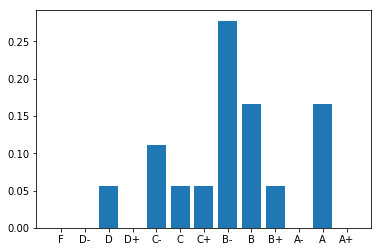

In [111]:
grades2 = ['F','D-','D','D+','C-','C','C+','B-','B','B+','A-','A','A+']
plt.bar(x = grades2, height = data.loc[20,gradepctcols])
plt.show()

The histogram below shows the number of classes against number of letter grades received by students.

The peak at zero indicates that there are about 500 pass no pass classes that we should deal with.

Although there are also some classes with very low letter grades received (< 10) the number of classes like that is exceptionally small so we can be assured that it will not skew our aggregate data analysis by much.

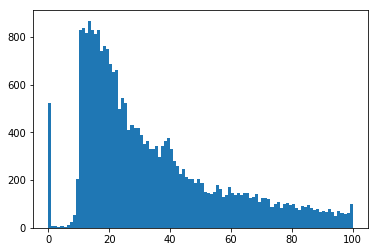

In [112]:
plt.hist(data[gradecols].sum(axis = 1), bins = 100, range = [0,100])
plt.show()

In [113]:
data.loc[data.loc[:,gradecols].sum(axis = 1) == 0].shape

(524, 58)

We notice that 524 classes are P/NP classes and should be dealt with separately.

Also, note that students who opt to pass / no pass a class should be excluded because they would skew results by perhaps not putting as much effort into a class as they would otherwise.

As such, we should split the data into pass-no-pass classes and letter grade classes.

In [114]:
pnpdata = data.loc[data.loc[:,gradecols].sum(axis = 1) == 0]
lgdata = data.loc[~(data.loc[:,gradecols].sum(axis = 1) == 0)]

Some initial questions to consider:
    - Is grade inflation a thing?
    - Are there professors who are more lenient than others?
    - Are certain departments more competitive than others?
    - Does the weather/seasons affect grade distributions?
    
In order the answer these questions, it might make sense to convert each grade into a GPA to get better numerical results such as the mean, median, quantiles and standard deviations of these distributions.

We will map GPA using the grade point scale found here: https://catalog.registrar.ucla.edu/ucla-catalog18-19-117.html

In [115]:
gradepts = [0,0.7,1.0,1.3,1.7,2.0,2.3,2.7,3.0,3.3,3.7,4.0,4.0]
gradedict = dict(zip(grades2,gradepts))
gradedict

{'F': 0,
 'D-': 0.7,
 'D': 1.0,
 'D+': 1.3,
 'C-': 1.7,
 'C': 2.0,
 'C+': 2.3,
 'B-': 2.7,
 'B': 3.0,
 'B+': 3.3,
 'A-': 3.7,
 'A': 4.0,
 'A+': 4.0}

For each observation, we extract its summary statistics

In [116]:
dist = [[gradepts[i]]*x for i,x in enumerate(data.loc[0,gradecols])]
raw = pd.Series([x for y in dist for x in y])
raw.describe()

count    59.000000
mean      2.816949
std       0.968496
min       0.000000
25%       2.300000
50%       3.000000
75%       3.300000
max       4.000000
dtype: float64

We put the above into a function and apply it over each row

In [117]:
def summstats(row):
    dist = [[gradepts[i]]*x for i,x in enumerate(row)]
    raw = pd.Series([x for y in dist for x in y])
    return(raw.describe())

In [118]:
## We will only apply it on the head for reference
lgdata.loc[:,gradecols].head().apply(summstats, axis = 1)

,count,mean,std,min,25%,50%,75%,max
0,59.0,2.816949,0.968496,0.0,2.3,3.0,3.3,4.0
1,172.0,3.083140,0.845771,0.0,2.7,3.0,4.0,4.0
2,195.0,3.086667,0.978915,0.0,2.5,3.3,4.0,4.0
4,63.0,3.211111,0.635790,1.7,2.7,3.3,3.7,4.0
5,63.0,3.471429,0.781113,0.0,3.3,3.7,4.0,4.0


Lets dive deeper into the data and see what kind of groupings we can get based on:
    - Term Quarter
    - Term Year

In [119]:
byTermYear = lgdata.groupby('term_year')[gradecols].sum().apply(summstats, axis = 1)
byTermYear

,count,mean,std,min,25%,50%,75%,max
term_year,,,,,,,,
2006,156260.0,3.163241,0.840706,0.0,2.7,3.3,4.0,4.0
2009,91144.0,3.188597,0.842559,0.0,2.7,3.3,4.0,4.0
2010,164337.0,3.226533,0.832589,0.0,3.0,3.3,4.0,4.0
2012,90511.0,3.203513,0.846366,0.0,2.7,3.3,4.0,4.0
2013,283815.0,3.232407,0.844706,0.0,3.0,3.3,4.0,4.0
2014,292149.0,3.246556,0.840442,0.0,3.0,3.3,4.0,4.0
2015,299388.0,3.264102,0.836828,0.0,3.0,3.7,4.0,4.0
2016,331840.0,3.306672,0.819213,0.0,3.0,3.7,4.0,4.0
2017,307304.0,3.325938,0.812562,0.0,3.0,3.7,4.0,4.0


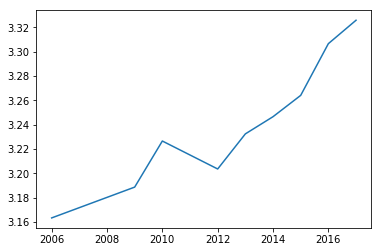

In [120]:
plt.plot(byTermYear.index, byTermYear['mean'])

From the above graph, we can clearly see an upward trend in terms of the total mean GPA received over the year. This seems to indicate a strong case for GPA inflation.

In [121]:
byTermQtr = lgdata.groupby('term_quarter')[gradecols].sum().apply(summstats, axis = 1)
byTermQtr

,count,mean,std,min,25%,50%,75%,max
term_quarter,,,,,,,,
FA,763513.0,3.241651,0.830726,0.0,3.0,3.3,4.0,4.0
SP,575498.0,3.262474,0.838594,0.0,3.0,3.7,4.0,4.0
SU,121031.0,3.313068,0.876166,0.0,3.0,3.7,4.0,4.0
WI,556706.0,3.258460,0.823600,0.0,3.0,3.3,4.0,4.0


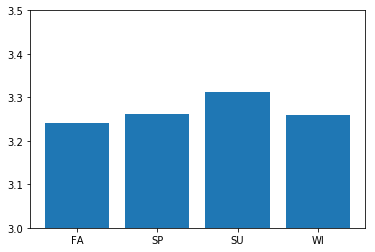

In [122]:
plt.bar(byTermQtr.index, byTermQtr['mean'])
plt.ylim(3,3.5)
plt.show()

From the histogram above, we can also see that classes taught in the summer tend to give out higher grades

In [123]:
byProf = lgdata.groupby('prof_name')[gradecols].sum().apply(summstats, axis = 1)

In [124]:
byProf[byProf['count'] > 500].sort_values('mean',ascending = False).head()

,count,mean,std,min,25%,50%,75%,max
prof_name,,,,,,,,
i-nyoman-wenten,851.0,3.999295,0.014535,3.7,4.0,4.0,4.0,4.0
donald-neuen,1266.0,3.987046,0.114649,1.7,4.0,4.0,4.0,4.0
john-b-ullmen,541.0,3.986876,0.097343,3.0,4.0,4.0,4.0,4.0
chuc-v-bui,553.0,3.986618,0.069691,3.3,4.0,4.0,4.0,4.0
abhiman-kaushal,1595.0,3.982194,0.151269,0.0,4.0,4.0,4.0,4.0


We have found a professor who gives almost all A/A+ for his ETHNOMU 161B class

In [125]:
lgdata.loc[lgdata['prof_name'] == 'i-nyoman-wenten', gradecols + ['prof_name','course_name']]

,grade_F,grade_Dm,grade_D,grade_Dp,grade_Cm,grade_C,grade_Cp,grade_Bm,grade_B,grade_Bp,grade_Am,grade_A,grade_Ap,prof_name,course_name
3041,0,0,0,0,0,0,0,0,0,0,0,25,2,i-nyoman-wenten,ETHNOMU 161B
4379,0,0,0,0,0,0,0,0,0,0,0,50,1,i-nyoman-wenten,ETHNOMU 161B
5771,0,0,0,0,0,0,0,0,0,0,0,45,2,i-nyoman-wenten,ETHNOMU 161B
7717,0,0,0,0,0,0,0,0,0,0,0,36,3,i-nyoman-wenten,ETHNOMU 161B
9630,0,0,0,0,0,0,0,0,0,0,0,37,1,i-nyoman-wenten,ETHNOMU 161B
10884,0,0,0,0,0,0,0,0,0,0,0,38,1,i-nyoman-wenten,ETHNOMU 161B
12194,0,0,0,0,0,0,0,0,0,0,0,35,2,i-nyoman-wenten,ETHNOMU 161B
14224,0,0,0,0,0,0,0,0,0,0,0,8,1,i-nyoman-wenten,ETHNOMU 91B
14225,0,0,0,0,0,0,0,0,0,0,0,50,1,i-nyoman-wenten,ETHNOMU 161B
15523,0,0,0,0,0,0,0,0,0,0,0,41,3,i-nyoman-wenten,ETHNOMU 161B


In [126]:
byCourse = lgdata.groupby('course_name')[gradecols].sum().apply(summstats, axis = 1)

In [127]:
byCourse[byCourse['count'] > 500].sort_values('mean', ascending = False).head()

,count,mean,std,min,25%,50%,75%,max
course_name,,,,,,,,
ETHNOMU 161B,643.0,3.999067,0.016718,3.7,4.0,4.0,4.0,4.0
LIFESCI 192B,609.0,3.997537,0.027093,3.7,4.0,4.0,4.0,4.0
MUSIC 90F,667.0,3.990255,0.161574,0.0,4.0,4.0,4.0,4.0
SOC WLF 195,593.0,3.988364,0.074090,3.0,4.0,4.0,4.0,4.0
ETHNOMU 161F,828.0,3.983937,0.094698,3.0,4.0,4.0,4.0,4.0


Again we notice that ETHNOMU 161B comes up, but we also see LIFESCI 192B

In [128]:
byDept = lgdata.groupby('dept_short_name')[gradecols].sum().apply(summstats, axis = 1)
byDept[byDept['count'] > 500].sort_values('mean', ascending = False).head()

,count,mean,std,min,25%,50%,75%,max
dept_short_name,,,,,,,,
ARMENIA,1354.0,3.901551,0.273958,0.0,4.0,4.0,4.0,4.0
VIETMSE,1277.0,3.847142,0.417770,0.0,4.0,4.0,4.0,4.0
MIL SCI,1370.0,3.843431,0.386785,0.0,4.0,4.0,4.0,4.0
IRANIAN,2471.0,3.836787,0.391502,0.0,3.7,4.0,4.0,4.0
HIN-URD,1701.0,3.829571,0.418501,0.0,3.7,4.0,4.0,4.0


Here, we see that certain departments like Armenian, Vietnamese and Military Sciences give an overwhelming amount of A/A+

In [129]:
byDivision = lgdata.groupby('division')[gradecols].sum().apply(summstats, axis = 1)
byDivision.sort_values('mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
division,,,,,,,,
DEN,13.0,4.000000,0.000000,4.0,4.0,4.0,4.0,4.0
EIS,15891.0,3.731634,0.547348,0.0,3.7,4.0,4.0,4.0
AA,40950.0,3.677897,0.556785,0.0,3.7,4.0,4.0,4.0
MUS,51502.0,3.670786,0.633083,0.0,3.7,4.0,4.0,4.0
TFT,63855.0,3.644684,0.595764,0.0,3.3,4.0,4.0,4.0
NUR,11444.0,3.641122,0.483331,0.0,3.3,3.7,4.0,4.0
PH,15592.0,3.601007,0.569145,0.0,3.3,4.0,4.0,4.0
PA,9132.0,3.560151,0.596464,0.0,3.3,3.7,4.0,4.0
LAW,230.0,3.551304,0.678151,0.0,3.3,3.7,4.0,4.0


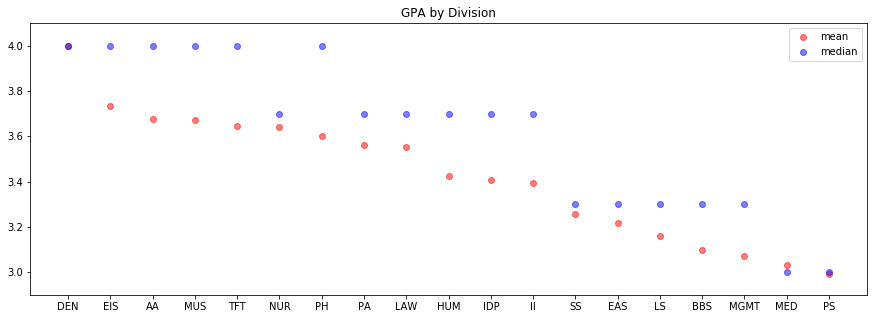

In [190]:
gpa_by_division = byDivision.sort_values('mean', ascending = False)
plt.figure(figsize=(15,5))
plt.plot(gpa_by_division.index, gpa_by_division['mean'], 'ro', label = "mean", alpha = .5)
plt.plot(gpa_by_division.index,gpa_by_division['50%'], 'bo', label = "median", alpha = .5)
plt.legend()
plt.ylim(2.9,4.1)
plt.title("GPA by Division")
plt.show()

Dentistry should be taken as an outlier since there are only 15 of such course instances taken and GPA is 4.0

The divisions at the top of the GPA spread are:
- Education and Information Systems
- School of Arts and Architecture
- School of Music
- School of Theater, Film and Television

Meanwhile, the majors at the bottom of the spread with medians of 3.0 are:
- Physical Sciences
- Medicine

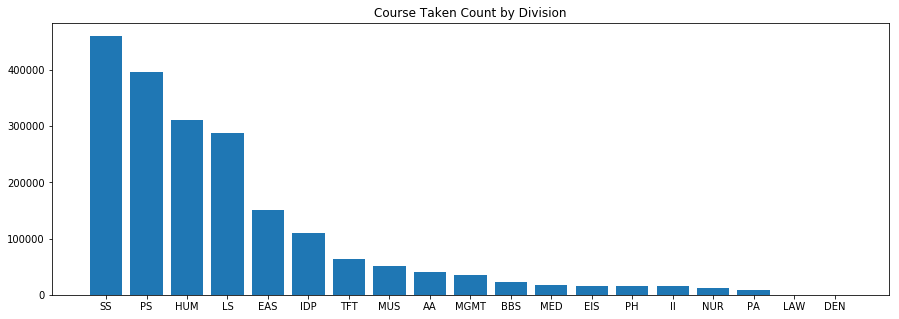

In [201]:
gpa_by_division = byDivision.sort_values('count', ascending = False)
plt.figure(figsize=(15,5))
plt.bar(gpa_by_division.index, gpa_by_division['count'])
plt.title("Course Taken Count by Division")
plt.show()

We also see from here that the most popular classes are from:
- Social Sciences
- Physical Sciences
- Humanities
- Life Sciences

This is to be expected because these form the bulk of the classes in the College of Letters and Science

Meanwhile, the least popular classes are from:
- School of Law
- School of Dentistry
- School of Public Affairs
- School of Nursing